# Session Based Recommendation - 프로젝트 : Movielens 영화 SBR





In [1]:
import os
import datetime as tf
from pathlib import Path

import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:

data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

In [3]:
print(data.shape)

(1000209, 4)


In [4]:
data.describe()

,UserId,ItemId,Rating,Time
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


## Step 1. 데이터의 전처리

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [5]:
data.iloc[0]['Time']

978300019

In [6]:
data.loc[0]

UserId            1
ItemId         1193
Rating            5
Time      978300760
Name: 0, dtype: int64

In [7]:
# 60분 = 60 * 60 = 3600초

In [8]:
data = data.sort_values(['UserId', 'Time'])

In [9]:
session_id = []

prev_time = 0
prev_user = 0
curr_session = 0

for one_data in data.iloc:
    if one_data['Time'] - prev_time > 3600 or prev_user != one_data['UserId']:
        curr_session += 1
    prev_time = one_data['Time']
    prev_user = one_data['UserId']
    session_id.append(curr_session)
    
data['SessionId'] = session_id

In [10]:
print(data.shape)
data.nunique()

(1000209, 5)


UserId         6040
ItemId         3706
Rating            5
Time         458455
SessionId     24413
dtype: int64

In [11]:
data['DateTime'] = pd.to_datetime(data['Time'], unit='s')

In [12]:
print(data[50:70])

     UserId  ItemId  Rating       Time  SessionId            DateTime
32        1    1566       4  978824330          2 2001-01-06 23:38:50
34        1    1907       4  978824330          2 2001-01-06 23:38:50
25        1      48       5  978824351          2 2001-01-06 23:39:11
130       2    1198       4  978298124          3 2000-12-31 21:28:44
64        2    1210       4  978298151          3 2000-12-31 21:29:11
71        2    1217       3  978298151          3 2000-12-31 21:29:11
134       2    2717       3  978298196          3 2000-12-31 21:29:56
88        2    1293       5  978298261          3 2000-12-31 21:31:01
170       2    2943       4  978298372          3 2000-12-31 21:32:52
106       2    1225       5  978298391          3 2000-12-31 21:33:11
120       2    1193       5  978298413          3 2000-12-31 21:33:33
172       2     318       5  978298413          3 2000-12-31 21:33:33
70        2    3030       4  978298434          3 2000-12-31 21:33:54
105       2    2858 

In [13]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1         40
2         13
3        129
4         51
5         21
        ... 
24409      7
24410     14
24411      1
24412     21
24413      1
Length: 24413, dtype: int64

In [14]:
session_length.median(), session_length.mean()

(6.0, 40.97034366935649)

In [15]:
session_length.min(), session_length.max()

(1, 1290)

In [16]:
session_length.quantile(0.999)

770.1760000000068

In [17]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

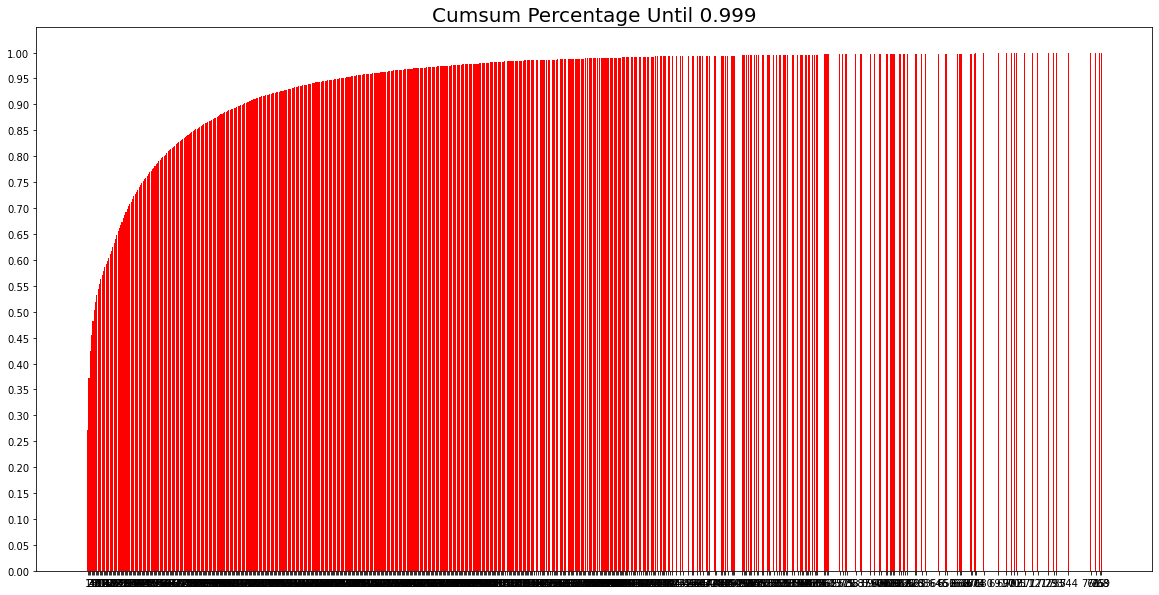

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [19]:
oldest = data['DateTime'].min()
latest = data['DateTime'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


데이터는 3년간의 정보가 들어있습니다. 최근 2년의 데이터만을 사용해볼까요?

In [20]:
import datetime
month_ago = latest - datetime.timedelta(730)
new_data = data[data['DateTime'] > month_ago]
new_data

,UserId,ItemId,Rating,Time,SessionId,DateTime
2327,19,318,4,994556598,43,2001-07-08 01:43:18
2492,19,1234,5,994556636,43,2001-07-08 01:43:56
2503,20,1694,3,1009669071,45,2001-12-29 23:37:51
2512,20,1468,3,1009669071,45,2001-12-29 23:37:51
2513,20,3717,2,1009669071,45,2001-12-29 23:37:51
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,24412,2001-08-10 14:40:29
999988,6040,1921,4,997454464,24412,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,24412,2001-08-10 14:41:04
1000167,6040,161,3,997454486,24412,2001-08-10 14:41:26


In [21]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        #data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [22]:
new_data = cleanse_recursive(new_data, shortest=2, least_click=5)
new_data.shape

(65231, 6)

In [23]:
train_ago = latest - datetime.timedelta(90)
train = new_data[new_data['DateTime'] < train_ago]

test_ago = latest - datetime.timedelta(10)
test = new_data[new_data['DateTime'] > test_ago]

In [24]:
valid_condition = (new_data['DateTime'] > train_ago) & (new_data['DateTime'] < test_ago)
valid = new_data[valid_condition]

In [25]:
print(train.shape)
print("Sessions : ", train['SessionId'].nunique())
print("Items : ", train['ItemId'].nunique())
print("First Time : ", train['DateTime'].min())
print("Last Time : ", train['DateTime'].max())

(60946, 6)
Sessions :  4215
Items :  3271
First Time :  2001-02-28 19:06:53
Last Time :  2002-11-30 13:47:32


In [26]:
print(valid.shape)
print("Sessions : ", valid['SessionId'].nunique())
print("Items : ", valid['ItemId'].nunique())
print("First Time : ", valid['DateTime'].min())
print("Last Time : ", valid['DateTime'].max())

(3812, 6)
Sessions :  299
Items :  1633
First Time :  2002-11-30 21:53:04
Last Time :  2003-02-18 17:36:46


In [27]:
print(test.shape)
print("Sessions : ", test['SessionId'].nunique())
print("Items : ", test['ItemId'].nunique())
print("First Time : ", test['DateTime'].min())
print("Last Time : ", test['DateTime'].max())

(473, 6)
Sessions :  42
Items :  417
First Time :  2003-02-18 19:10:24
Last Time :  2003-02-28 17:49:50


In [28]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}
"""
for index, item_id in enumerate(valid['ItemId'].unique()):
    id2idx[item_id] = index
    
for index, item_id in enumerate(test['ItemId'].unique()):
    id2idx[item_id] = index
"""
def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

In [29]:
train = indexing(train, id2idx)
valid = indexing(valid, id2idx)
test = indexing(test, id2idx)

In [30]:
train

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
2327,19,318,4,994556598,43,2001-07-08 01:43:18,0
2492,19,1234,5,994556636,43,2001-07-08 01:43:56,1
2503,20,1694,3,1009669071,45,2001-12-29 23:37:51,2
2512,20,1468,3,1009669071,45,2001-12-29 23:37:51,3
2513,20,3717,2,1009669071,45,2001-12-29 23:37:51,4
...,...,...,...,...,...,...,...
999923,6040,232,5,997454398,24412,2001-08-10 14:39:58,875
1000019,6040,2917,4,997454429,24412,2001-08-10 14:40:29,1471
999988,6040,1921,4,997454464,24412,2001-08-10 14:41:04,811
1000172,6040,1784,3,997454464,24412,2001-08-10 14:41:04,357


In [31]:
valid

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
5200,36,2269,5,1040544350,86,2002-12-22 08:05:50,1829
5256,36,1701,4,1040544350,86,2002-12-22 08:05:50,1536
5184,36,2694,3,1040544494,86,2002-12-22 08:08:14,570
5364,36,3786,4,1040544521,86,2002-12-22 08:08:41,707
5262,36,2369,4,1040544564,86,2002-12-22 08:09:24,916
...,...,...,...,...,...,...,...
984167,5948,1283,5,1043068249,24102,2003-01-20 13:10:49,109
984206,5948,1304,5,1043068456,24102,2003-01-20 13:14:16,259
984173,5948,1288,4,1043068509,24102,2003-01-20 13:15:09,1016
983996,5948,3467,5,1043068562,24102,2003-01-20 13:16:02,1183


In [32]:
test

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
33889,229,3089,4,1046325739,1028,2003-02-27 06:02:19,1072
33994,229,2839,5,1046325855,1028,2003-02-27 06:04:15,3122
53023,349,163,3,1045946587,1588,2003-02-22 20:43:07,1281
53130,349,1228,4,1045946639,1588,2003-02-22 20:43:59,878
53120,349,548,2,1045946656,1588,2003-02-22 20:44:16,1801
...,...,...,...,...,...,...,...
984731,5950,3948,4,1046369637,24123,2003-02-27 18:13:57,470
984682,5950,3578,4,1046369670,24123,2003-02-27 18:14:30,285
984475,5950,3793,3,1046369710,24123,2003-02-27 18:15:10,284
984660,5950,3555,2,1046369737,24123,2003-02-27 18:15:37,197


In [33]:
save_path = data_path / 'processed2'
save_path.mkdir(parents=True, exist_ok = True)

train.to_pickle(save_path / 'train.pkl')
valid.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성

실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.

In [34]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [35]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
2327,19,318,4,994556598,43,2001-07-08 01:43:18,0
2492,19,1234,5,994556636,43,2001-07-08 01:43:56,1
2503,20,1694,3,1009669071,45,2001-12-29 23:37:51,2
2512,20,1468,3,1009669071,45,2001-12-29 23:37:51,3
2513,20,3717,2,1009669071,45,2001-12-29 23:37:51,4
2517,20,2858,4,1009669071,45,2001-12-29 23:37:51,5
2504,20,2641,4,1009669115,45,2001-12-29 23:38:35,6
2510,20,1375,3,1009669115,45,2001-12-29 23:38:35,7
2520,20,3753,5,1009669116,45,2001-12-29 23:38:36,8
2507,20,3527,4,1009669181,45,2001-12-29 23:39:41,9


In [36]:
train_dataset.click_offsets

array([    0,     2,    13, ..., 60915, 60925, 60946], dtype=int32)

In [37]:
train_dataset.session_idx

array([   0,    1,    2, ..., 4212, 4213, 4214])

In [38]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=16):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [39]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
2327,19,318,4,994556598,43,2001-07-08 01:43:18,0
2492,19,1234,5,994556636,43,2001-07-08 01:43:56,1
2503,20,1694,3,1009669071,45,2001-12-29 23:37:51,2
2512,20,1468,3,1009669071,45,2001-12-29 23:37:51,3
2513,20,3717,2,1009669071,45,2001-12-29 23:37:51,4
2517,20,2858,4,1009669071,45,2001-12-29 23:37:51,5
2504,20,2641,4,1009669115,45,2001-12-29 23:38:35,6
2510,20,1375,3,1009669115,45,2001-12-29 23:38:35,7
2520,20,3753,5,1009669116,45,2001-12-29 23:38:36,8
2507,20,3527,4,1009669181,45,2001-12-29 23:39:41,9


In [40]:
iter_ex = iter(train_data_loader)

In [41]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  2 13 23]
Label Item Idx are :       [ 1  3 14 24]
Previous Masked Input Idx are []


## Step 3. 모델 구성

이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.



In [48]:
# recall_k가 없어서 진행이 안되므로 추가
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [50]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [51]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, valid, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)

In [52]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 1, 3271)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      498450    
_________________________________________________________________
dropout_1 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (32, 3271)                166821    
Total params: 665,271
Trainable params: 665,271
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.



In [53]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [54]:
train_model(model, args)

Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0, train_loss=7.4]      

	 - Recall@20 epoch 1: 0.040053
	 - MRR@20    epoch 1: 0.009778



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0, train_loss=7.12]     

	 - Recall@20 epoch 2: 0.054577
	 - MRR@20    epoch 2: 0.012829



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.87]

	 - Recall@20 epoch 3: 0.075264
	 - MRR@20    epoch 3: 0.017623



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0938, train_loss=6.55]

	 - Recall@20 epoch 4: 0.088468
	 - MRR@20    epoch 4: 0.021377



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.32]

	 - Recall@20 epoch 5: 0.102993
	 - MRR@20    epoch 5: 0.028080



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0, train_loss=6.17]     

	 - Recall@20 epoch 6: 0.123680
	 - MRR@20    epoch 6: 0.033305



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.85] 

	 - Recall@20 epoch 7: 0.133803
	 - MRR@20    epoch 7: 0.040652



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.57] 

	 - Recall@20 epoch 8: 0.143486
	 - MRR@20    epoch 8: 0.043537



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.48]

	 - Recall@20 epoch 9: 0.149208
	 - MRR@20    epoch 9: 0.044701



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.45] 

	 - Recall@20 epoch 10: 0.143926
	 - MRR@20    epoch 10: 0.044744



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.34] 

	 - Recall@20 epoch 11: 0.145246
	 - MRR@20    epoch 11: 0.045427



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.1] 

	 - Recall@20 epoch 12: 0.142606
	 - MRR@20    epoch 12: 0.045558



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.88]

	 - Recall@20 epoch 13: 0.143486
	 - MRR@20    epoch 13: 0.045839



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.01]

	 - Recall@20 epoch 14: 0.137324
	 - MRR@20    epoch 14: 0.045090



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.92] 

	 - Recall@20 epoch 15: 0.136444
	 - MRR@20    epoch 15: 0.044829



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0312, train_loss=4.85]

	 - Recall@20 epoch 16: 0.133363
	 - MRR@20    epoch 16: 0.044401



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.69]

	 - Recall@20 epoch 17: 0.132042
	 - MRR@20    epoch 17: 0.044344



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.63] 

	 - Recall@20 epoch 18: 0.130722
	 - MRR@20    epoch 18: 0.044026



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.59] 

	 - Recall@20 epoch 19: 0.132482
	 - MRR@20    epoch 19: 0.044878



Evaluation:  65%|██████▌   | 71/109 [00:14<00:07,  4.81it/s]

	 - Recall@20 epoch 20: 0.128521
	 - MRR@20    epoch 20: 0.044426



## Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [55]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [56]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  15%|█▌        | 2/13 [00:00<00:02,  4.72it/s]

	 - Recall@20: 0.109375
	 - MRR@20: 0.028760

